<a href="https://colab.research.google.com/github/manaswini0707/Modules/blob/main/Module_9_Project_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: CNN Project

## Module coordinator: Ekta Gavas

In this project, you will understand how you can perform emotion recognition using CNNs in a step-by-step manner. To make your task easier, we provide you the starter code for the project. It is expected that you should try to understand the project statement properly and perform the tasks in sequence. We will be using Pytorch framework for the implementation. You need to fill in the missing code parts to achieve a particular task. At the end, you will have a basic implementation ready for an emotion detection application.

Basic steps involved in Emotion Recognition:
- Face detection
- Building classifier
- Classifying emotions

We will use a popular FER2013 dataset for this project. 

## Task 1: Explore the dataset
The dataset contains 48 x 48 grayscale facial images of faces.The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image. The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral).

Import libraries

In [1]:
# We have imported the necessary packages here. Feel free to import anything more you need!
import torch
import torchvision
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dlib
import cv2
from PIL import Image

### Download and load dataset

In [2]:
!gdown https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
!unzip fer2013.csv.zip

Downloading...
From: https://drive.google.com/uc?id=1YrNrok2Z1udWWIpejXIdLk7duUq87s0N
To: /content/fer2013.csv.zip
100% 101M/101M [00:00<00:00, 296MB/s] 
Archive:  fer2013.csv.zip
replace fer2013.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [3]:
# Load the dataset csv using pandas package. It displays the data in tabular form
emotion_data = pd.read_csv('./fer2013.csv')
print(emotion_data)

       emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 columns]


In [4]:
# Class dictionary for dataset
classes = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

### Visualize a few images from dataset

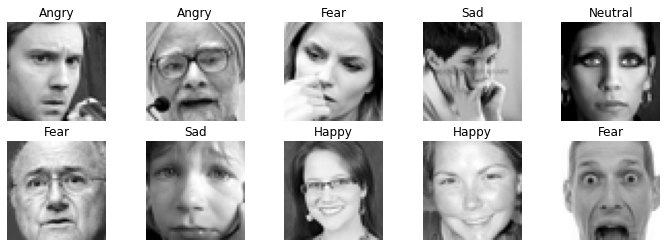

In [5]:
fig = plt.figure(figsize=(12,4))
for i in range(10):
  ax = plt.subplot(2,5,i+1)
  # This is how we access ith row in 'pixels' column in the dataset table
  img = emotion_data.iloc[i]['pixels'].split(' ') # Converting into array of ints 
  img = np.array(img).astype(int)

  # Labels for our dataset
  label = int(emotion_data.iloc[i]['emotion'])
  ax.imshow(img.reshape((48,48)), cmap='gray')
  ax.set_title(classes[label])
  ax.set_axis_off()
plt.show()

In [6]:
names, counts = np.unique(emotion_data['Usage'].to_numpy(), return_counts=True)
print('Number of samples in {} = {}'.format(names[0], counts[0])) #testset
print('Number of samples in {} = {}'.format(names[1], counts[1])) #valset
print('Number of samples in {} = {}'.format(names[2], counts[2])) #trainset

Number of samples in PrivateTest = 3589
Number of samples in PublicTest = 3589
Number of samples in Training = 28709


### Distribution of class labels

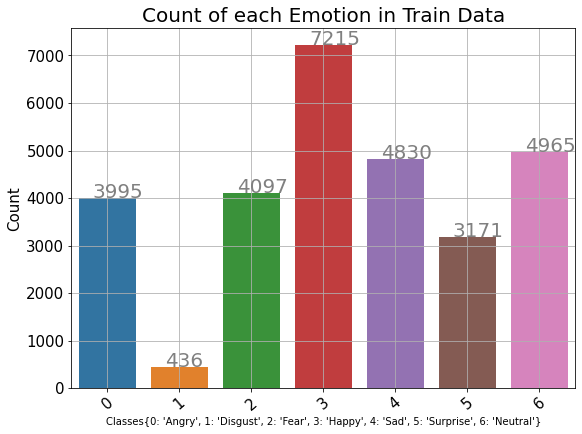

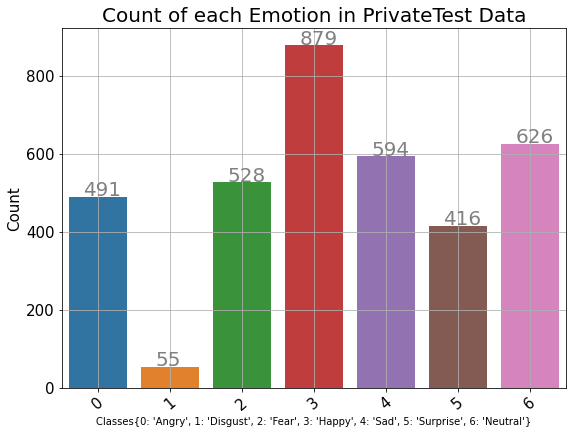

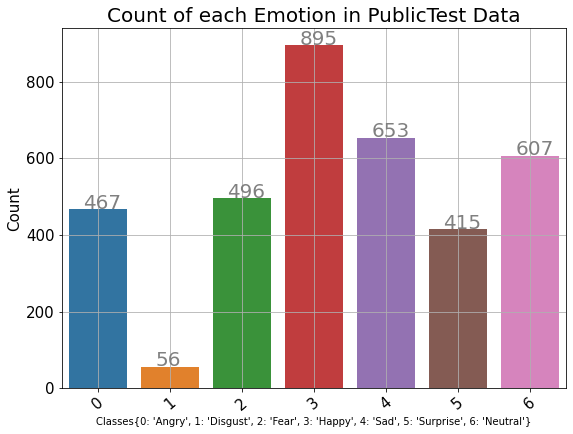

In [7]:
# Plot bar chart showing number of samples per class in the train set
temp_train = emotion_data.loc[emotion_data['Usage'] == 'Training']
df_temp_train = temp_train.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in Train Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_train)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

### Task: Similarly, write the code below to plot the charts for remaining two sets also.
temp_test = emotion_data.loc[emotion_data['Usage'] == 'PrivateTest']
df_temp_test = temp_test.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in PrivateTest Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_test)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

temp_test = emotion_data.loc[emotion_data['Usage'] == 'PublicTest']
df_temp_test = temp_test.sort_values(by = "emotion", inplace = False)
fig = plt.figure(figsize = (7, 5))
ax = fig.add_axes([0,0,1,1])
ax.set_title("Count of each Emotion in PublicTest Data", fontsize = 20)
sns.countplot(x = "emotion", data = df_temp_test)
plt.grid()
for i in ax.patches:
    ax.text(x = i.get_x() + 0.2, y = i.get_height()+1.5, s = str(i.get_height()), fontsize = 20, color = "grey")
plt.xlabel("Classes"+ str(classes))
plt.ylabel("Count", fontsize = 15)
plt.tick_params(labelsize = 15)
plt.xticks(rotation = 40)
plt.show()

Note the imbalance in the data through above graphs.

Face detection: Many applications involving facial images as input data require face detection in the pipeline at this step. Here, we localise the face in the given image removing the irrelevant parts, making the face centered and occupying most of the part in the image. As mentioned earlier, our dataset already has more or less centered faces, so we will skip this step for now but when using some other dataset or using your own images (eg. from webcam) as you will do later, you can do this step to get a proper cropped face from the image.

## Task 2: Data preprocessing

### Creating train, validation and test sets

In [8]:
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

for index, row in emotion_data.iterrows():
  k = row['pixels'].split(" ")

  if row['Usage'] == 'Training':
    X_train.append(np.array(k))
    y_train.append(row['emotion'])

  # Similarly write the conditions for test and val splits here
  ###### YOUR CODE HERE  ######
  if row['Usage'] == 'PublicTest':
    X_test.append(np.array(k))
    y_test.append(row['emotion'])

  if row['Usage'] == 'PrivateTest':
    X_val.append(np.array(k))
    y_val.append(row['emotion'])

X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape: ', X_train.shape, y_train.shape)
print('Validation set shape: ', X_val.shape, y_val.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (28709, 2304) (28709,)
Validation set shape:  (3589, 2304) (3589,)
Testing set shape:  (3589, 2304) (3589,)


In [9]:
# To get data between 0 and 1
X_train = X_train.astype(float) / 255.
X_test = X_test.astype(float) / 255.
X_val = X_val.astype(float) / 255.

We will define a dataset wrapper over Pytorch Dataset class which takes in the numpy arrays we created and returns a sample with required preprocessing.

In [10]:
class Fer2013Dataset(Dataset):
  def __init__(self, x, y, transforms=None):
    self.x = x.reshape((-1, 48, 48))
    self.y = y
    self.transforms= transforms

  def __getitem__(self, index):
    img, y = self.x[index], self.y[index]

    if self.transforms is not None:
        img = self.transforms(img)
    return img, y

  def __len__(self):
    return len(self.y)

In [11]:
batch_size=32

transform = transforms.ToTensor()

# Create tensor dataset from above tensors
train_dataset = Fer2013Dataset(X_train, y_train, transforms=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)

val_dataset = Fer2013Dataset(X_val, y_val, transforms=transform)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)

test_dataset = Fer2013Dataset(X_test, y_test, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

In [12]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 1, 48, 48])
torch.Size([32])


## Task 3: Building a CNN model

In [34]:
# Define your CNN architecture here
# To start with, let's say you can create a model with 4 relu-activated convs, 
# each followed by a pooling layer. Then, you can add 2-3 fully connected layers

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool1 = nn.MaxPool2d(3, 3)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(3, 1)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool3 = nn.MaxPool2d(3, 1)
        self.conv4 = nn.Conv2d(64, 64, 3)
        self.pool4 = nn.MaxPool2d(3, 1)
        self.fc1 = nn.Linear(64*3*3, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 7)

    def forward(self,x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.pool4(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))

        return x

In [35]:
# Device (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool4): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=576, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=7, bias=True)
)


In [15]:
device

'cpu'

In [19]:
model.double()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2592, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=7, bias=True)
)

### Training/Testing functions

In [44]:
def train(model, train_loader, val_loader, loss_func, optimizer, num_epochs, stopping_threshold):

  # Training mode
  model.train()

  train_losses = []
  train_acc = []
  val_losses = []
  val_acc = []

  # Train the model
  for epoch in range(num_epochs):
    running_loss = 0
    running_acc = 0
    running_val_loss = 0
    running_val_acc = 0
    for i, (images, labels) in enumerate(train_loader):
      
      # clear gradients for this training step   
      optimizer.zero_grad()           
      
      # Forward pass
      output = model(images.to(device).float())

      # Calculate loss
      loss = loss_func(output, labels.to(device))

      # Backpropagation, compute gradients 
      loss.backward()

      # Apply gradients             
      optimizer.step()                
      
      # Running loss
      running_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels.to(device)).sum()
      running_acc += correct

      # Average loss and acc values 
      epoch_loss = running_loss / len(train_loader.dataset)
      epoch_acc = running_acc / len(train_loader.dataset)
    
    for i, (images, labels) in enumerate(val_loader):         
      
      # Forward pass
      output = model(images.to(device).float())

      # Calculate loss
      loss = loss_func(output, labels.to(device))
      
      # Running loss
      running_val_loss += loss.item()

      # indices of max probabilities
      _, preds = torch.max(output, dim=1)

      # Calculate number of correct predictions
      correct = (preds.float() == labels.to(device)).sum()
      running_val_acc += correct

      # Average loss and acc values 
      epoch_val_loss = running_val_loss / len(val_loader.dataset)
      epoch_val_acc = running_val_acc / len(val_loader.dataset)

    train_losses.append(epoch_loss)
    train_acc.append(epoch_acc.cpu())

    val_losses.append(epoch_val_loss)
    val_acc.append(epoch_val_acc.cpu())

    print ('Epoch {}/{}, Loss: {:.4f}, Accuracy: {:.4f}     Val_Loss: {:.4f}, Val_Accuracy: {:.4f}'.format(epoch + 1, num_epochs, epoch_loss, epoch_acc*100, epoch_val_loss, epoch_val_acc*100))

    # # if score dosn't improved for the past 'stopping_threshold' epochs --> stop the training
    # if (np.asarray(val_losses[(0-stopping_threshold):]) > min(val_losses)).sum() == stopping_threshold:
    #   break
  return train_losses, train_acc, val_losses, val_acc

In [45]:
def test_model(model, testloader):
  correct = 0
  total = 0
  # Deactivate autograd engine (don't compute grads since we're not training)
  with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network
        outputs = model(images)
        # The class with the highest value is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

  print('Accuracy of the network: %d %%' % (
      100 * correct / total))
  return predicted.float(), labels

## Task 4: Training & Evaluation

### Train the model

In [49]:
import torch.optim as optim
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer with learning rate
optimizer = optim.Adam(model.parameters(), lr = 0.001)   # Pick an optimizer you think is suitable

history = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, stopping_threshold = 8)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 1/10, Loss: 0.0584, Accuracy: 26.8104     Val_Loss: 0.0574, Val_Accuracy: 31.4851
Epoch 2/10, Loss: 0.0568, Accuracy: 32.5055     Val_Loss: 0.0564, Val_Accuracy: 35.9432
Epoch 3/10, Loss: 0.0560, Accuracy: 35.7310     Val_Loss: 0.0557, Val_Accuracy: 37.9214
Epoch 4/10, Loss: 0.0551, Accuracy: 39.0958     Val_Loss: 0.0548, Val_Accuracy: 41.2650
Epoch 5/10, Loss: 0.0544, Accuracy: 41.3773     Val_Loss: 0.0544, Val_Accuracy: 42.6303
Epoch 6/10, Loss: 0.0540, Accuracy: 42.9656     Val_Loss: 0.0540, Val_Accuracy: 44.8036
Epoch 7/10, Loss: 0.0536, Accuracy: 44.1360     Val_Loss: 0.0541, Val_Accuracy: 43.7726
Epoch 8/10, Loss: 0.0535, Accuracy: 44.5714     Val_Loss: 0.0545, Val_Accuracy: 42.4074
Epoch 9/10, Loss: 0.0532, Accuracy: 45.6616     Val_Loss: 0.0540, Val_Accuracy: 43.5497
Epoch 10/10, Loss: 0.0531, Accuracy: 45.8532     Val_Loss: 0.0536, Val_Accuracy: 45.2215


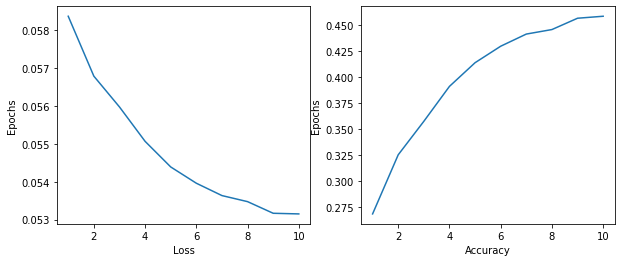

In [50]:
# You can fine-tune your model looking at below plots
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2, 1)
ax.plot(np.arange(1,len(history[0])+1),history[0])
plt.xlabel('Loss')
plt.ylabel('Epochs')

ax = fig.add_subplot(1,2, 2)
ax.plot(np.arange(1,len(history[1])+1),history[1])
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.show()

### Evaluate your model

In [51]:
# Visualize top K predictions
def visualize_prediction(image, model, k=3):
  model.eval()

  preds = model(image.unsqueeze(1).float())

  topk = torch.topk(preds, k, dim=1)
  topk = topk.indices.numpy()
  print('Top {} Predictions'.format(k))
  for i in range(3):
    print('{}) {}'.format(i+1, classes[topk[0][i]]))

  plt.imshow(image[0].numpy(), cmap='gray')
  plt.show()

Top 3 Predictions
1) Sad
2) Happy
3) Neutral


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


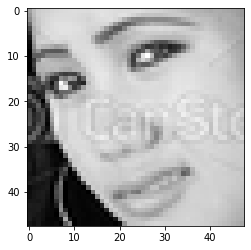


True label:  Disgust


In [52]:
image, label = test_dataset[1]
model.float()
visualize_prediction(image, model)
print('\nTrue label: ', classes[int(label)])

In [53]:
# Print accuracy on test data
model.double()
true_labels, predicted_labels = test_model(model, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network: 45 %


Bonus: 
If you feel confident enough, you can try replacing your CNN model with a pretrained model like resnet or vgg and check the performance.